# First model attempt

https://towardsdatascience.com/time-series-analysis-on-multivariate-data-in-tensorflow-2f0591088502

In [1]:
import sys
sys.path.insert(1, '/Users/lauradellantonio/neuefische/Capstone/capstone')

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns

import functions.functions_data
import functions.functions_mask_wearing
import functions.functions_corona_stats
import functions.functions_HDI
import functions.functions_mask_req

pd.set_option('display.max_columns', None) # To display all columns

import warnings
warnings.filterwarnings(action='ignore')

from datetime import timedelta

import tensorflow as tf
import matplotlib.pyplot as plt
import os
import datetime
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from math import sqrt
from sklearn.metrics import mean_squared_error

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Reading in and adjusting data

In [3]:
# Reading in survey data and joining it into one dataframe
dfs_country = functions.functions_data.get_data("/Users/lauradellantonio/neuefische/Capstone/capstone/data/CMU_Global_data/Full_Survey_Data/country/smooth/", "country")
countries = pd.concat(dfs_country, ignore_index=True)

Read in data completed.


In [4]:
# Adding the real COVID numbers to the dataframe
covid_cases = pd.read_csv("/Users/lauradellantonio/neuefische/Capstone/capstone/data/Corona_stats/owid-covid-data.csv")
countries = functions.functions_corona_stats.merge_corona_stats(countries,covid_cases)

Merging corona stats completed.


In [5]:
# Sorting out the date column within the dataframe
countries = functions.functions_data.insert_month(countries)

Created month column.


In [6]:
# Dealing with the NaN in the mask wearing column
countries = functions.functions_mask_wearing.deal_with_NaNs_masks(countries)

NaNs before update: 163383
NaNs after update: 0
Updated.


In [7]:
# Getting the dictionaries for the hdi and the hdi-levels.
dict_hdi, dict_hdi_levels = functions.functions_HDI.get_hdi("/Users/lauradellantonio/neuefische/Capstone/capstone/data","hdro_statistical_data_tables_1_15_d1_d5.xlsx")

# Creating a new column with the hdi and the hdi-levels in the regions dataframe
countries = functions.functions_HDI.create_hdi_columns(countries, dict_hdi, dict_hdi_levels)

Creating dictionaries for hdi and hdi-levels completed.
Creating hdi list completed.
Creating hdi-level list completed.


In [8]:
# Adding the mask wearing requirements to the dataframe
mask_wearing_requirements = pd.read_csv("/Users/lauradellantonio/neuefische/Capstone/capstone/data/data-nbhtq.csv")
countries = functions.functions_mask_req.merge_mask_requirements(countries,mask_wearing_requirements)
countries = functions.functions_mask_req.add_requirement_by_date(countries)

Merging mask wearing requirements completed.
Feature engineering completed.


## Selecting relevant columns

In [9]:
df = countries.copy()

In [10]:
df = df[df["age_bucket"]=="overall"]
df = df[df["gender"]=="overall"]

In [11]:
date = ["date"]

columns_general = ["iso_code", "hdi", "median_age"]

columns_general_no_iso = ["hdi", "median_age"]

columns_social_distancing = ["smoothed_pct_worked_outside_home_weighted", "smoothed_pct_grocery_outside_home_weighted", "smoothed_pct_ate_outside_home_weighted", 
                             "smoothed_pct_attended_public_event_weighted", "smoothed_pct_used_public_transit_weighted", 
                             "smoothed_pct_direct_contact_with_non_hh_weighted", "smoothed_pct_no_public_weighted"]

columns_mask_wearing = ["smoothed_pct_wear_mask_all_time_weighted", "smoothed_pct_wear_mask_most_time_weighted"]

columns_mask_req = ["cur_mask_recommended", "cur_mask_not_required", "cur_mask_not_required_recommended", "cur_mask_not_required_universal", 
                    "cur_mask_required_part_country", "cur_mask_everywhere_in_public", "cur_mask_public_indoors", "cur_mask_public_transport"]

columns_pred = ["total_cases_per_million"]

columns_interest = date + columns_general + columns_social_distancing + columns_mask_wearing + columns_mask_req + columns_pred

columns_rev_scale = columns_general_no_iso + columns_social_distancing + columns_mask_wearing + columns_mask_req + columns_pred

In [12]:
df_select = df[columns_interest]

In [13]:
df_select.set_index("date", inplace=True)

### Trying to deal with NaN values

In [14]:
df_select[df_select["total_cases_per_million"].isna()].iso_code.unique()

array(['VEN', 'HKG'], dtype=object)

We are going to exclude data from Hong Kong as there is too much missing data.  
We are going to fill the one missing value from Venezuela with the total cases from the day before as data is only missing for one day.

In [15]:
df_select = df_select[df_select.iso_code != "HKG"]

In [16]:
df_select['total_cases_per_million']=df_select['total_cases_per_million'].fillna(method='ffill')

Deal with NaNs in 'median_age' column

In [17]:
df_select.loc[df_select['iso_code'] == 'DMA', "median_age"] = 34.9
df_select.loc[df_select['iso_code'] == 'AND', "median_age"] = 46.2

### Dataset without iso code

In [18]:
df_no_iso = df_select.drop("iso_code", axis=1)

## Attempting the neural network

### Autocorrelation
It means the correlation of the present values with its past values. An autocorrelation function measures the degree of similarity of the present series with that of its lagged series (past values). Spikes above the blue region, indication that the series is autocorrelated. Similarly, you can check autocorrelation for other series of the dataset also.

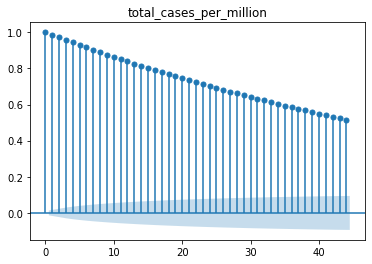

In [19]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_no_iso['total_cases_per_million'])
plt.title('total_cases_per_million')

plt.show()

###  Johansen cointegration test
A time series is said to be stationary if its corresponding statistical properties like mean, standard deviation and autocorrelation remain constant throughout the time.  
If the eigenvalues are less than one than the series is said to be stationary.


In [20]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

johan_test = df_no_iso
coint_johansen(johan_test,-1,1).eig

/Users/lauradellantonio/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/vector_ar/vecm.py:577: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn("Critical values are only available for time series "


array([2.33692510e-02, 1.90428951e-02, 1.75661237e-02, 1.42326191e-02,
       1.18044150e-02, 1.04491637e-02, 7.50527341e-03, 7.23486075e-03,
       5.91298195e-03, 5.08477134e-03, 4.45783417e-03, 3.88144523e-03,
       3.35127162e-03, 3.14088795e-03, 2.96467726e-03, 2.59120673e-03,
       2.41119826e-03, 2.08725517e-03, 1.81619570e-03, 2.60784898e-05])

In [21]:
#Sort data according to date
df_no_iso.sort_index(inplace=True)

In [22]:
#divide the data into train and test data
train_size = int(len(df_no_iso) * 0.80)
test_size = len(df_no_iso) - train_size
train, test = df_no_iso[0:train_size], df_no_iso[train_size:len(df_no_iso)]

In [23]:
to_scale = ["median_age", "smoothed_pct_worked_outside_home_weighted", "smoothed_pct_grocery_outside_home_weighted", 
            "smoothed_pct_ate_outside_home_weighted", "smoothed_pct_attended_public_event_weighted", 
            "smoothed_pct_used_public_transit_weighted", "smoothed_pct_direct_contact_with_non_hh_weighted", 
            "smoothed_pct_no_public_weighted", "smoothed_pct_wear_mask_all_time_weighted", 
            "smoothed_pct_wear_mask_most_time_weighted", "total_cases_per_million"]

In [24]:
#scale the values
scaler = MinMaxScaler()
train[to_scale] = scaler.fit_transform(train[to_scale])

In [25]:
test[to_scale] = scaler.transform(test[to_scale])

In [26]:
#index the data into dependent and independent variables
train_X, train_y = train.drop("total_cases_per_million", axis=1), train["total_cases_per_million"]
test_X, test_y =  test.drop("total_cases_per_million", axis=1), test["total_cases_per_million"]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(17016, 19) (17016,) (4254, 19) (4254,)


In [27]:
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values

In [28]:
#convert data into suitable dimension for using it as input in LSTM network
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(17016, 1, 19) (17016,) (4254, 1, 19) (4254,)


Epoch 1/13
237/237 - 1s - loss: 0.0646 - val_loss: 0.1163
Epoch 2/13
237/237 - 0s - loss: 0.0526 - val_loss: 0.1148
Epoch 3/13
237/237 - 0s - loss: 0.0501 - val_loss: 0.1129
Epoch 4/13
237/237 - 0s - loss: 0.0492 - val_loss: 0.1112
Epoch 5/13
237/237 - 0s - loss: 0.0481 - val_loss: 0.1097
Epoch 6/13
237/237 - 0s - loss: 0.0470 - val_loss: 0.1080
Epoch 7/13
237/237 - 0s - loss: 0.0469 - val_loss: 0.1067
Epoch 8/13
237/237 - 0s - loss: 0.0461 - val_loss: 0.1062
Epoch 9/13
237/237 - 0s - loss: 0.0459 - val_loss: 0.1053
Epoch 10/13
237/237 - 0s - loss: 0.0453 - val_loss: 0.1052
Epoch 11/13
237/237 - 0s - loss: 0.0447 - val_loss: 0.1043
Epoch 12/13
237/237 - 0s - loss: 0.0448 - val_loss: 0.1037
Epoch 13/13
237/237 - 0s - loss: 0.0443 - val_loss: 0.1027


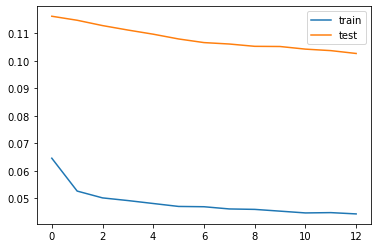

In [29]:
model = Sequential()
model.add(LSTM(13, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=13, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [30]:
#prediction on training and testing data
train_predict = model.predict(train_X)    
test_predict = model.predict(test_X)       

#converting from three dimension to two dimension
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [31]:
inv_train_predict = concatenate((train_X, train_predict), axis=1)
inv_test_predict = concatenate((test_X, test_predict), axis=1)

In [32]:
prediction = pd.DataFrame([test_y,test_predict]).T

In [33]:
prediction = prediction.rename(columns={0: "true_value", 1: "pred"})

In [34]:
prediction.pred = prediction.pred.apply(lambda x: x[0])

In [35]:
prediction

,true_value,pred
0,0.0121336,0.019810
1,0.558535,0.157853
2,0.0502246,0.037849
3,0.0379488,0.102745
4,0.00361407,0.043033
...,...,...
4249,0.3105,0.119311
4250,0.0245402,0.020264
4251,0.168223,0.142083
4252,0.499391,0.175258


(0.0, 1.4)

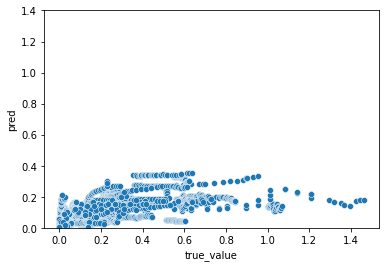

In [41]:
sns.scatterplot(data=prediction, x="true_value", y="pred")
plt.ylim(0, 1.4)

In [37]:
inv_train_predict = pd.DataFrame(inv_train_predict, columns = columns_rev_scale)

In [38]:
#transforming to original scale
inv_train_predict[to_scale] = scaler.inverse_transform(inv_train_predict[to_scale])

In [42]:
inv_test_predict[to_scale] = scaler.inverse_transform(inv_test_predict[to_scale])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [40]:
#transforming to original scale
inv_train_predict = scaler.inverse_transform(inv_train_predict)
inv_test_predict = scaler.inverse_transform(inv_test_predict)

#predicted values on training data
inv_train_predict = inv_train_predict[:,0]
inv_train_predict

#predicted values on testing data
inv_test_predict = inv_test_predict[:,0]
inv_test_predict 

ValueError: operands could not be broadcast together with shapes (17016,20) (11,) (17016,20) 